In [2]:
# Bibliotecas

import os
import random
import numpy as np
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
pasta = "treino/imagens"
treino_split, val_split = 0.7, 0.15

# Listando todas as categorias (subdiretórios) na pasta raiz
categorias = [x[0] for x in os.walk(pasta) if x[0]][1:]
print(categorias)

['imagens\\uso_epi_correto', 'imagens\\uso_epi_falha']


In [4]:
# Função auxiliar para carregas a imagem e retorná-la e o vetor de entrada
def obter_imagem(caminho):
    img = image.load_img(caminho, target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando as imagens da pasta raiz

In [5]:
dados = []

for valor, categoria in enumerate(categorias):
    imagens = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(categoria) for f in filenames
              if os.path.splitext(f)[1].lower() in [".jpg", ".png", ".jpeg"]]
    for cont, img_path in enumerate(imagens):
        try:
            img, x = obter_imagem(img_path)
            frase_imagem = f"{cont}º imagem"
            #print(frase_imagem)

            try:
                dados.append({"x":np.array(x[0]), "y":valor})
            except Exception as e:
                print(f"Erro: {e}")
        
        except Exception as erro:
            print(f"Erro: {erro}")

# contando o número de classes
num_classes = len(categorias)
#print(num_classes)

Randomizando a ordem dos dados

In [6]:
random.shuffle(dados) # Boa prática, para dividir treino, validação e teste (embaralhamento)

Criando divisão dos dados treinamento = 70%, validação = 15%, teste = 15%

In [7]:
idx_val = int(treino_split * len(dados))
idx_test = int((treino_split + val_split) * len(dados))
treino = dados[:idx_val]
validacao = dados[idx_val:idx_test]
teste = dados[idx_test:]

print(f"Tamanho dos dados de treino {len(treino)}")
print(f"Tamanho dos dados de validação {len(validacao)}")
print(f"Tamanho dos dados de teste {len(teste)}")

Tamanho dos dados de treino 146
Tamanho dos dados de validação 31
Tamanho dos dados de teste 32


Dados separados por rótulos

In [8]:
# Separando as entradas e rótulos para o conjunto de treino
x_treino = np.array([t["x"] for t in treino])
y_treino = [t["y"] for t in treino]

# Separando as entradas e rótulos para o conjunto de validação
x_validacao = np.array([v["x"] for v in validacao])
y_validacao = [v["y"] for v in validacao]

# Separando as entradas e rótulos para o conjunto de teste
x_teste = np.array([t["x"] for t in teste])
y_teste = [t["y"] for t in teste]

#print(y_teste)

Pré-processando os dados, certificando que sejam float32 e normalizando entre 0 e 1

In [9]:
# Normalizando os dados
x_treino = x_treino.astype("float32") / 255
x_validacao = x_validacao.astype("float32") / 255
x_teste = x_teste.astype("float32") / 255

# Convertendo rótulos em One-hot
y_treino = keras.utils.to_categorical(y_treino, num_classes)
y_validacao = keras.utils.to_categorical(y_validacao, num_classes)
y_teste = keras.utils.to_categorical(y_teste, num_classes)
#print(y_teste.shape)

Resumo dos dados

In [10]:
# Resumo
print(f"Carregado {len(dados)} imagens e {num_classes} categorias")
print(f"Dados de treino = {len(x_treino)} / validação = {len(x_validacao)} / teste = {len(x_teste)}")
print(f"Forma dados de treinamento: {x_treino.shape}")
print(f"Forma rótulos de treinamento: {y_treino.shape}")

Carregado 209 imagens e 2 categorias
Dados de treino = 146 / validação = 31 / teste = 32
Forma dados de treinamento: (146, 224, 224, 3)
Forma rótulos de treinamento: (146, 2)


Visualizando alguns dados

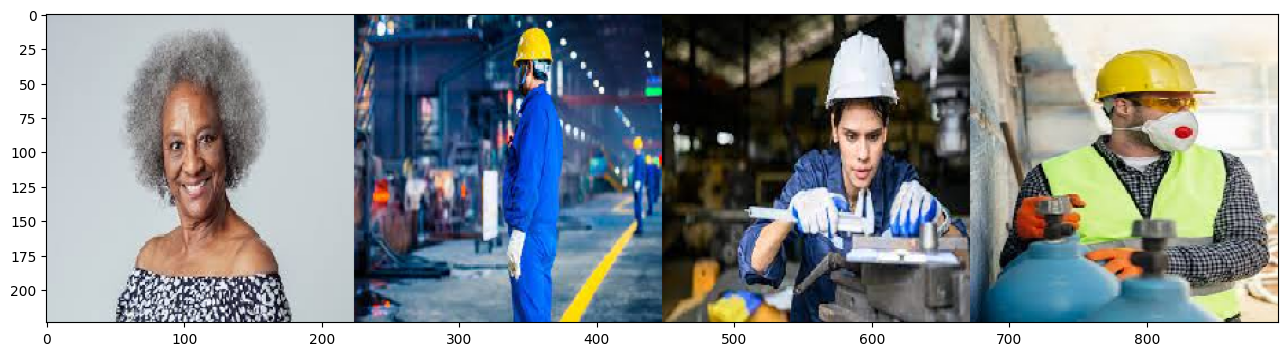

In [11]:
imagens = [os.path.join(dp, f) for dp, dn, filenames in os.walk(pasta) for f in filenames if os.path.splitext(f)[1].lower() in [".jpg", ".png", ".jpeg"]]
idx = [int(len(imagens) * random.random()) for i in range(4)]
imgs = [image.load_img(imagens[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)

Carregando o modelo do keras

In [12]:
vgg = keras.applications.VGG16(weights="imagenet", include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
inp = vgg.input # Referência a camada de entraada VGG
new_classification_layer = Dense(num_classes, activation="softmax") # Criando uma nova camada softmax com num_classes neurônios
out = new_classification_layer(vgg.layers[-2].output) # Conectando a nova camada à penúltima camada do VGG e fazendo referência a ela
model = Model(inp, out) # Criando uma nova rede entre inp e out

In [14]:
# Tornando todas as camadas não treináveis, congelandos os pesos, (exceto pela última camada)
for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

# Garantindo que última camada não seja treinada
for l, layer in enumerate(model.layers[-1:]):
    layer.trainable = True

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [15]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               restore_best_weights=True)

history = model.fit(x_treino, y_treino,
                    batch_size=8,
                    epochs = 10,
                    validation_data=(x_validacao, y_validacao),
                    callbacks=[early_stopping])

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4272 - loss: 1.1091 - val_accuracy: 0.6774 - val_loss: 0.5157
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5745 - loss: 0.6148 - val_accuracy: 0.5806 - val_loss: 0.6905
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6601 - loss: 0.6439 - val_accuracy: 0.8710 - val_loss: 0.3196
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7646 - loss: 0.4481 - val_accuracy: 0.9677 - val_loss: 0.3145
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8653 - loss: 0.3687 - val_accuracy: 0.7419 - val_loss: 0.3612
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7569 - loss: 0.4973 - val_accuracy: 0.7419 - val_loss: 0.3171
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8680 - loss: 0.3372 - val_accuracy: 0.9677 - val_loss: 0.2729
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9182 - loss: 0.2899 - val_accuracy: 0.8710 - val_loss:

(0.0, 1.0)

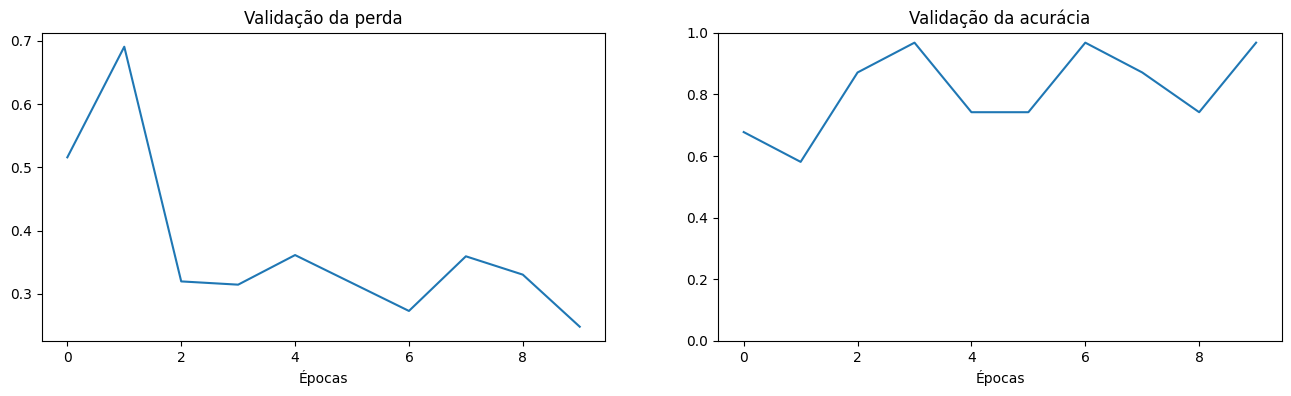

In [16]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validação da perda")
ax.set_xlabel("Épocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validação da acurácia")
ax2.set_xlabel("Épocas")
ax2.set_ylim(0,1)

In [17]:
perda, acuracia = model.evaluate(x_teste, y_teste, verbose=0)
print("Teste de perda: ", perda)
print("Teste de acurácia: ", acuracia)

Teste de perda:  0.36523038148880005
Teste de acurácia:  0.875


Aplicando modelo a uma imagem

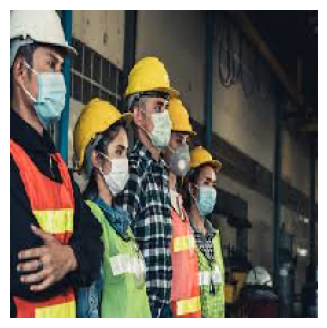

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Probabilidade de ser a classe 0 (correto): 99.9996542930603
Probabilidade de ser a classe 1 (errado): 0.0003437453415244818


In [18]:
img, x = obter_imagem(f"{pasta}/uso_epi_correto/1.jpg")

# Mostrar imagem
plt.figure(figsize=(16, 4))
plt.imshow(img)
plt.axis("off")
plt.show()

probabilidade = model.predict([x])
probabilidade = probabilidade[0]

print(f"Probabilidade de ser a classe 0 (correto): {probabilidade[0] * 100}")
print(f"Probabilidade de ser a classe 1 (errado): {probabilidade[1] * 100}")

In [19]:
#model.save("modelo_seguranca_epi.keras")